## PTB数据集的预处理
PTB(Penn Treebank Dataset)文本数据集是目前语言模型学习中使用最为广泛的数据集。目前只关注data文件夹下的三个文件。这三个数据文件中的数据已经经过预处理，相邻单词之间用空格隔开。数据集中共包含了9998个不同单词词汇，加上稀有词语的特殊符号和语句结束标记符在内，一共是10000个词汇。在使用perplexity比较不同语言模型时，文本的预处理和词汇表必须保持一致。<br/>
按词频顺序为每个词编号，并保存到文件：

In [2]:
# 该模块便于不同编码文件之间的读取和写入
import codecs
import collections
from operator import itemgetter

# 训练集数据文件
RAW_DATA = './Data/simple-examples/data/ptb.train.txt'
# 输出的词汇表文件
VOCAB_OUT = './Data/ptb.vocab'

counter = collections.Counter()
with codecs.open(RAW_DATA, "r", "utf-8") as f:
    for line in f:
        for word in line.strip().split():
            counter[word] += 1

# 按词频顺序对单词进行排序
sorted_word_to_cnt = sorted(counter.items(), 
                            key=itemgetter(1), 
                            reverse=True)
sorted_words = [x[0] for x in sorted_word_to_cnt]

sorted_words = ['<eos>'] + sorted_words

with codecs.open(VOCAB_OUT, "w", "utf-8") as file_output:
    for word in sorted_words:
        file_output.write(word+"\n")

在确定了词汇表后，再将训练文件、测试文件等都根据词汇文件转化为单词编号。每个单词的编号就是它在词汇文件中的行号。

In [16]:
import codecs
import sys

RAW_DATA = './Data/simple-examples/data/ptb.train.txt'
VOCAB_OUT = './Data/ptb.vocab'
OUTPUT_DATA = './Data/ptb.train'

# 读取词汇表，并建立词汇到单词编号的映射
with codecs.open(VOCAB_OUT, "r", "utf-8") as f_vocab:
    vocab = [w.strip() for w in f_vocab.readlines()]
word_to_id = {k:v for (k, v) in zip(vocab, range(len(vocab)))}

def get_id(word):
    return word_to_id[word] if word in word_to_id else word_to_id["<unk>"]

fin = codecs.open(RAW_DATA, "r", "utf-8")
fout = codecs.open(OUTPUT_DATA, "w", "utf-8")

for line in fin:
    words = line.strip().split() + ["<eos>"]
    out_line = ' '.join([str(get_id(w)) for w in words]) + "\n"
    fout.write(out_line)

fin.close()
fout.close()

在实际工程中，通常使用TFRecord格式来提高读写效率。虽然预处理原则上可以放在TensorFlow的Dataset框架中与读取文本同时进行，但在工程实践上，保存处理好的数据有几个重要的优点：
- 在调试模型的过程中，可以保证不同模型采取的预处理步骤相同；
- 减小文件体积，节省磁盘读取空间；
- 方便对预处理步骤本身进行debug；

## PTB数据的batching方法
在文本数据中，由于每个句子的长度不同，又无法像图像一样调整到固定维度，因此在对文本数据进行batching时需要采取一些特殊操作。最常见的办法是使用填充(padding)将统一batch内的句子长度补齐。但在PTB数据集中，是存在上下文之间的关联的。语言模型为了利用上下文关系，必须将前面句子的信息传递到后面的句子。因此通常采用另外一种batching方法。<br/>
如果模型大小不限制，那么理想状态是将整个文档前后相连起来作为模型的输入，但是这样会导致计算图过大，同时也会导致梯度爆炸等问题。因此为了解决此问题，将长序列切割为固定长度的子序列。循环神经网络在处理完一个子序列后，它最后的隐藏状态将赋值到下一个序列中作为初始值。这样在前向计算时，效果等同于一次性顺序地读取了整个问题；而在反向传播时，梯度则只在每个子序列内部传播。<br/>
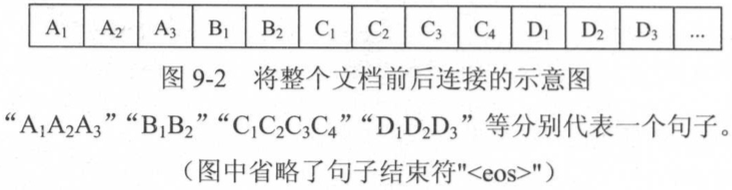

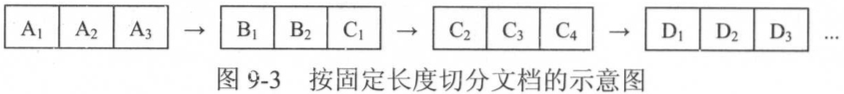
上图展示了再没有batching时切分文档的方法。为了利用计算时的并行能力，我们希望每一次计算可以对多个句子进行并行处理，同时又要尽量保证batch之间的上下文连续。解决方法是，先将整个文档切分成若干连续段落，再让batch中的每一个位置负责其中一段。例如，如果batch大小是4，则先将整个文档平均分成4个子序列，让batch中的每一个位置负责其中一个子序列，这样每个子文档内部的所有数据仍可以被顺序处理。<br/>

In [17]:
import numpy as np
import tensorflow as tf

TRAIN_DATA = './Data/ptb.train'
TRAIN_BATCH_SIZE = 20
TRAIN_NUM_STEP = 35

def read_data(file_path):
    with open(file_path, "r") as fin:
        # 将整个文档读进一个长字符串
        id_string = ' '.join([line.strip() for line in fin.readlines()])
    # 将读取的单词编号转为整数
    id_list = [int(w) for w in id_string.split()]
    return id_list

def make_batches(id_list, batch_size, num_step):
    # 计算总batch数量。
    num_batches = (len(id_list)-1) // (batch_size * num_step)
    # 将数据整理成一个维度为[batch_size, num_batches*num_step]二维数组
    data = np.array(id_list[:num_batches * batch_size * num_step])
    data = np.reshape(data, [batch_size, num_batches * num_step])
    # 沿着第二个维度将数据切分成num_batches个batch，存入一个数组
    data_batches = np.split(data, num_batches, axis=1)
    
    # 这里得到RNN每一步输出所需要预测的下一个单词
    label = np.array(id_list[1: num_batches * batch_size * num_step+1])
    label = np.reshape(label, [batch_size, num_batches * num_step])
    label_batches = np.split(label, num_batches, axis=1)
    
    return list(zip(data_batches, label_batches))

def main():
    train_batches = make_batches(read_data(TRAIN_DATA), 
                                 TRAIN_BATCH_SIZE, TRAIN_NUM_STEP)

if __name__ == "__main__":
    main()

## 基于循环神经网络的神经语言模型
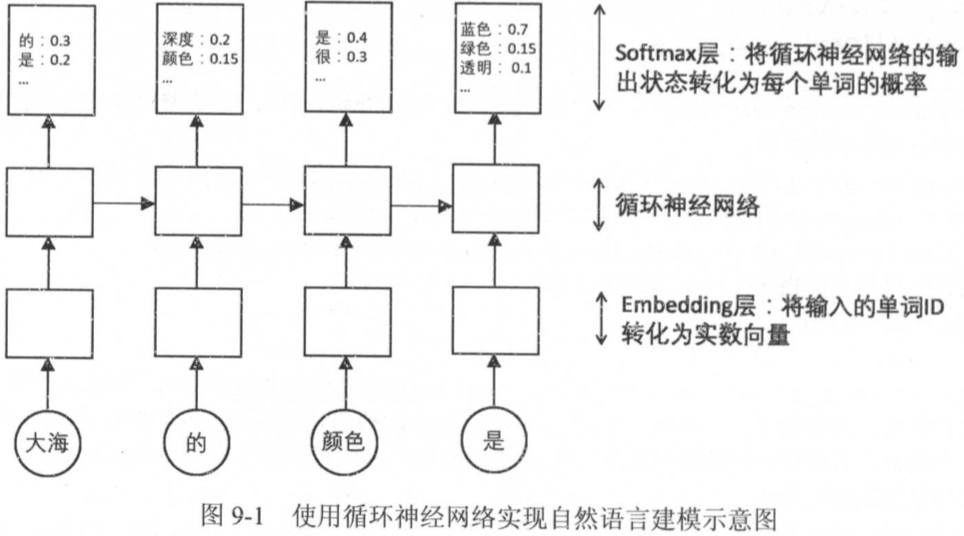
- **词向量层**
在输入层，每个单词用一个实数向量表示，这个向量被称为词向量(word embedding,"词嵌入")。使用词向量的作用：
1. 降低输入维度。词向量通常维度在200~1000之间。
2. 增加语义信息。

假设词向量的维度为EMB_SIZE，词汇表的大小为VOCAB_SIZE，那么所有单词的词向量可以放入一个大小为VOCAB_SIZE * EMB_SIZE的矩阵内。在读取词向量时，可以调用tf.nn.embedding_lookup方法。<br/>
```
embedding = tf.get_variable("embedding", [VOCAB_SIZE, EMB_SIZE])
# input_data的维度是batch_size * num_steps
# input_embedding的维度是batch_size * num_steps * EMB_SIZE
input_embedding = tf.nn.embedding_lookup(embedding, input_data)
```
- **Softmax层**<br/>
Softmax层的作用是将循环神经网络的输出转化为一个单词表中每个单词的输出概率。需要两个步骤：<br/>

1.使用一个线性映射将循环神经网络的输出映射为一个维度与词汇表大小相同的向量。这一步称为logits。<br/>
```
# 定义线性映射用到的参数。
# HIDDEN_SIZE是循环神经网络的隐藏状态维度，VOCAB_SIZE是词汇表大小
weight = tf.get_variable("weight", [HIDDENT_SIZE, VOCAB_SIZE])
bias = tf.get_variable("bias", [VOCAB_SIZE])
# 计算线性映射
# output是RNN输出，维度为[batch_size*num_steps, HIDDEN_SIZE]
logits = tf.nn.bias_add(tf.matmul(output, weight), bias)
```
2.调用softmax方法将logits转化为加和为1的概率。<br/>
```
# prob的维度与logits的维度相同
probs = tf.nn.softmax(logits)
```
模型训练通常并不关心概率的具体取值，而更关心最终的log perplexity。因此可以调用tf.nn.sparse_softmax_cross_entropy_with_logits方法直接计算log perplexity作为损失函数：<br/>
```
# labels：[batch_size*num_steps]的一维数组
# logits：[batch_size*num_steps, HIDDEN_SIZE]
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.reshape(self.targets, [-1]), logits=logits)
```
- **通过共享参数减少参数数量** <br/>
Softmax层和词向量层的参数数量与词汇表大小VOCAB_SIZE成正比。由于VOCAB_SIZE的数值通常较大，而HIDDEN_SIZE相对较小，导致softmax和embedding在整个网络的参数数量中占有很大比例。有研究指出，如果共享词向量层和Softmax层的参数，不仅可以大幅减少参数数量，还能提高最终模型效果。